In [25]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tensorflow as tf
from torchvision import transforms
from torchvision.utils import save_image


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
dirName = "txt/"
k = 10
d = 5
t = 0.2
matrix_l = []
for i in range(100):
    t_f = t*i
    t_Str = "{0:0.1f}".format(t_f)
    filename = dirName + "mesh_20_10_" + t_Str + ".txt"
    if i%5==0:
        filename = dirName + "mesh_20_10_" + str(int(t_f)) + ".txt"
    f = open ( filename , 'r')
    row_data = []
    row_data = [ line.split() for line in f]

    matrix_ind = np.array([])
    matrix_ind.resize((21,11))
    for i in range(len(row_data)):
        col = int(row_data[i][0])
        row = int(row_data[i][1])
        val = float(row_data[i][2])
        matrix_ind[col][row] = val
    matrix_l.append(matrix_ind)
matrix_arr = np.array(matrix_l)

In [51]:
matrix_arr.shape

(100, 21, 11)

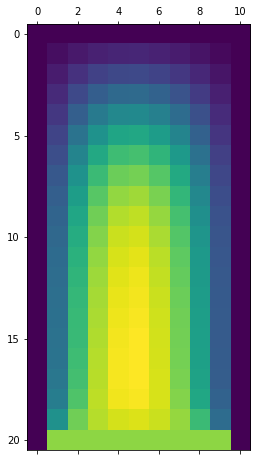

In [62]:
## %matplotlib inline 
from matplotlib import pyplot as plt
plt.matshow(matrix_arr[99,:,:])
plt.show()

In [48]:
tensor_l = []
for i in range(14):
    matrix_ten = np.copy(matrix_arr[(5*i):(5*i+5),:,:])
    ten = torch.from_numpy(matrix_ten)
    tensor_l.append(ten)


In [72]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 231
h_dim = 100
z_dim = 20
num_epochs = 15
batch_size = 5
learning_rate = 2e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=231, h_dim=100, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i in range(14):
        # Forward pass
        x = tensor_l[i]
        x = x.float()
        x = x.to(device).view(-1, image_size)

        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 21, 11)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 21, 11), out.view(-1, 1, 21, 11)], dim=3)
        
        x_array = x_concat.numpy()[:, ::-1, :, :]
#         save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [10/1875], Reconst Loss: 702.7940
Epoch[2/15], Step [10/1875], Reconst Loss: 580.1472
Epoch[3/15], Step [10/1875], Reconst Loss: 547.9337
Epoch[4/15], Step [10/1875], Reconst Loss: 558.2807
Epoch[5/15], Step [10/1875], Reconst Loss: 533.1476
Epoch[6/15], Step [10/1875], Reconst Loss: 530.1355
Epoch[7/15], Step [10/1875], Reconst Loss: 534.1951
Epoch[8/15], Step [10/1875], Reconst Loss: 530.5612
Epoch[9/15], Step [10/1875], Reconst Loss: 535.0482
Epoch[10/15], Step [10/1875], Reconst Loss: 527.3244
Epoch[11/15], Step [10/1875], Reconst Loss: 529.5754
Epoch[12/15], Step [10/1875], Reconst Loss: 522.0005
Epoch[13/15], Step [10/1875], Reconst Loss: 519.8321
Epoch[14/15], Step [10/1875], Reconst Loss: 531.1380
Epoch[15/15], Step [10/1875], Reconst Loss: 515.9803


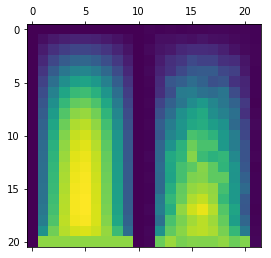

In [71]:
## %matplotlib inline 
from matplotlib import pyplot as plt
plt.matshow(x_array[0,:,:,:].reshape(21,22))
plt.show()

In [80]:
txt = x_array[0,:,:,11:].reshape(21,11)
str_txt = ""
for i in range(21):
    for j in range(11):
        str_txt = str_txt + str(txt[i,j]) + " "
    str_txt = str_txt +"\n"   

In [81]:
text_file = open("Output.txt", "w")
text_file.write(str_txt)
text_file.close()